#Fake News Classifier Using LSTM

`Long Short-Term Memory (LSTM)` is a type of `recurrent neural network (RNN)` that is commonly used for natural language processing (NLP) tasks such as fake news classification. There are several reasons why LSTM is a good choice for these tasks:

1. **Handling sequential data**: `LSTM` is designed to handle sequential data, which is the type of data that is common in NLP tasks. In fake news classification, the order of words in the news text is important, `LSTM` is able to capture the dependencies between the words in the text and make use of the context to improve the classification performance.

2. **Handling long-term dependencies**: In NLP tasks, the meaning of a word can depend on the context in which it is used, which can span a large number of words. Traditional `RNNs` can have difficulty handling such long-term dependencies, but `LSTMs` are specifically designed to handle these types of dependencies by using gates to control the flow of information through the network.

3. **Handling variable-length input**: `LSTMs` can handle variable-length input, which is common in NLP tasks where the length of text can vary. This is important in fake news classification, as news text can be of different lengths.

4. **Handling noise and irrelevant information**: In the case of fake news classification, the text data can be noisy or contain irrelevant information. `LSTM's` ability to selectively retain or discard information can help to handle such noise and irrelevant information.

5. **Handling overfitting**: `LSTM's` ability to store information for a long time in the cell state can help to prevent overfitting, as it can learn from the long-term dependencies in the data.

It's worth noting that `LSTM` is not the only deep learning model used for NLP and fake news classification, other deep learning models like `Transformer` and `BERT` can also be used. The choice of model depends on the specific characteristics of the data and the task.

## Data Pre-processing

We will first preprocess the data by cleaning the text, removing stopwords, and tokenizing the text. Then we will convert the text into numerical data by using techniques such as word embeddings, which map words to high-dimensional vectors.

After preprocessing the data, we will then use the `LSTM` model to classify the fake news. We will train the model on the training data and evaluate its performance on the test data. We will also use techniques such as cross-validation to ensure that our model is generalizing well to unseen data.

It is worth noting that we will be using a different dataset and deep learning model, which may produce different results compared to using machine learning models.

In [2]:
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/fake-news/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/fake-news/test.csv")

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


The "author" column in the dataset has a high number of missing values, and for the classification task, it is not a significant feature. Therefore, we will remove it from both the training and testing data. We also drop the "id" column.

In [6]:
train = train.drop(['author',"id"], axis=1)
test = test.drop(['author', "id"], axis=1)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   text    20761 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


We will remove the missing values from both the training and testing datasets. Additionally, we will combine the "title" and "text" columns into a single "all_text" column, similar to what we did before.

In [9]:
train = train.dropna()
test = test.dropna()

X_train = train["title"]
X_test = test["title"]

y_train = train['label']

X_train.shape, y_train.shape 

((20203,), (20203,))

## Onehot Representation

In the `one-hot` representation of text data, each word in the vocabulary is assigned a unique integer value based on the vocabulary size. The text is then represented as a vector of integers, where the value at each dimension corresponds to the integer value of the word. 

For example, consider a vocabulary of 3 words: ["dog", "cat", "bird"]. The words are assigned integer values as [1,2,3] respectively. If the text is "dog bird", the one-hot representation would be [1,3].

In [10]:
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot, text_to_word_sequence

import nltk,re
from nltk.corpus import stopwords

In [15]:
messages = train.copy()
messages.reset_index(inplace = True)

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

`PorterStemmer` is a type of stemmer algorithm that is one of the most widely-used stemmer algorithms for English text. The algorithm is based on a set of heuristic rules that are used to remove the common suffixes from words in order to arrive at the root form of the word.

The `NLTK (Natural Language Toolkit)` library in Python includes an implementation of the Porter stemmer algorithm.

In [17]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus_title = []
for i in range(0,len(messages)):
  review = re.sub("[^a-zA-Z]", " ", messages["title"][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus_title.append(review)

In [18]:
voc_size = 5000

onehot_title = [one_hot(words, voc_size) for words in corpus_title]
print(onehot_title[0])

[810, 4674, 301, 953, 2653, 4484, 1768, 4138, 2352, 2289]


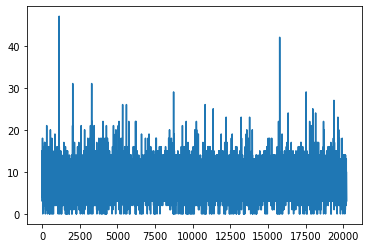

In [20]:
import matplotlib.pyplot as plt
plt.plot([len(title) for title in onehot_title])
plt.show()

In [ ]:
#onehot_text = [one_hot(messages['text'][i], voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for i in range(0, len(messages))]

##Embedding Representation (with only title)

In [21]:
sent_length = 30
embedded_title = pad_sequences(onehot_title, padding="post", maxlen=sent_length)

In [22]:
#creating model
emb_vec_features = 100
model = Sequential()
model.add(Embedding(voc_size, emb_vec_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           500000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
import numpy as np
X_train = np.array(embedded_title)
y_train = np.array(y_train)

In [24]:
X_train.shape, y_train.shape

((20203, 30), (20203,))

##Model Training

In [25]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
253/253 [==============================] - 9s 9ms/step - loss: 0.2868 - accuracy: 0.8673 - val_loss: 0.1934 - val_accuracy: 0.9213
Epoch 2/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1437 - accuracy: 0.9474 - val_loss: 0.1994 - val_accuracy: 0.9183
Epoch 3/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1104 - accuracy: 0.9615 - val_loss: 0.1998 - val_accuracy: 0.9169
Epoch 4/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0866 - accuracy: 0.9694 - val_loss: 0.2983 - val_accuracy: 0.9141
Epoch 5/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0707 - accuracy: 0.9750 - val_loss: 0.3290 - val_accuracy: 0.9109
Epoch 6/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0637 - accuracy: 0.9782 - val_loss: 0.3455 - val_accuracy: 0.9077
Epoch 7/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0470 - accuracy: 0.9839 - val_loss: 0.4248 - val_accuracy: 0.9032
Epoch 

We are getting **99.4**% training accuracy on and **92.2**% validation accuracy on the best epoch.  

##Adding Dropout Layers

In [26]:
from keras.layers import Dropout
##creating model with dropout
emb_vec_features = 40
model = Sequential()
model.add(Embedding(voc_size, emb_vec_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 30, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
253/253 [==============================] - 4s 8ms/step - loss: 0.3245 - accuracy: 0.8363 - val_loss: 0.1955 - val_accuracy: 0.9213
Epoch 2/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1572 - accuracy: 0.9422 - val_loss: 0.1963 - val_accuracy: 0.9235
Epoch 3/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1268 - accuracy: 0.9532 - val_loss: 0.2245 - val_accuracy: 0.9238
Epoch 4/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1053 - accuracy: 0.9624 - val_loss: 0.2339 - val_accuracy: 0.9235
Epoch 5/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0860 - accuracy: 0.9692 - val_loss: 0.2436 - val_accuracy: 0.9243
Epoch 6/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0694 - accuracy: 0.9753 - val_loss: 0.2965 - val_accuracy: 0.9191
Epoch 7/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0614 - accuracy: 0.9788 - val_loss: 0.3128 - val_accuracy: 0.9129
Epoch 

By adding dropout layers we get **92.86**% validation accuracy on best epoch.